# Auxiliary Learning Method
Auxiliary learning refers to a technique used in machine learning where multiple tasks or targets are jointly learned to improve the overall performance of a model. In this approach, an auxiliary task is introduced alongside the main task, and the model is trained to predict both the main task and the auxiliary task simultaneously.

The auxiliary task is typically chosen to provide additional information or regularization to the model, aiding in the learning process of the main task. The idea behind auxiliary learning is that the shared representation learned by the model for both the main and auxiliary tasks can capture more meaningful and robust features, leading to improved generalization and performance.

By training the model to simultaneously predict the main target (i.e., 'Class') and the auxiliary targets ('Beta', 'Gamma', 'Delta'), the model can benefit from the shared representation and potentially achieve better performance on the main task compared to training with the main task alone.

One common approach in auxiliary learning is to combine the losses of the main task and the auxiliary tasks during training, with appropriate weighting or regularization. This helps to balance the influence of the main and auxiliary tasks and ensure effective joint learning.

Overall, auxiliary learning is a technique that leverages additional tasks or targets to enhance the learning process and improve the performance of a machine learning model on the main task of interest.
## Method
1. We have a dataset called df_greeks which includes multiple categorical features that can serve as categorical targets. We aim to train an auxiliary learning model with the main target being 'Class', and the additional categorical targets being 'Beta', 'Gamma', and 'Delta'. 
2. To encode these categorical targets, we will employ one-hot encoding.

## Customized loss function for the auxiliary learning task
We have designed a customized loss function for the auxiliary learning task, which is a combination of two individual losses: loss1 and lamda times loss2. Here, lamda represents a weighting factor, typically set to 0.2 or another chosen value.

By incorporating both loss1 and lamda times loss2 in the loss function, we aim to balance the contributions of the main task and the auxiliary task during model training. This weighting factor allows us to adjust the relative importance of the two losses and control their influence on the overall training process.

By optimizing this loss function, we can effectively train the model to jointly learn both the main task and the auxiliary task, leveraging the benefits of auxiliary learning and potentially improving the model's performance on the desired objectives.



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


# Part I: Exploratory Data Analysis (EDA)

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from sklearn.utils import resample
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
dataset_directory = Path('/kaggle/input/icr-identify-age-related-conditions')
df_greeks = pd.read_csv(dataset_directory / 'greeks.csv') 
df_train = pd.read_csv(dataset_directory / 'train.csv')



## Data analysis: df_greeks 
* Supplemental metadata, only available for the training set.
* Beta, Gamma, Delta: Three experimental characteristics.
* Alpha: Identifies the type of age-related condition, if present.
    * A:  No age-related condition. Corresponds to class 0.
    * B, D, G: The three age-related conditions. Correspond to class 1.

In [6]:
unique_alpha =df_greeks['Alpha'].unique()
unique_beta = df_greeks['Beta'].unique()
unique_gamma =df_greeks['Gamma'].unique()
unique_delta = df_greeks['Delta'].unique()
print(unique_alpha, unique_beta, unique_gamma, unique_delta)

['B' 'A' 'D' 'G'] ['C' 'B' 'A'] ['G' 'M' 'F' 'N' 'E' 'H' 'A' 'B'] ['D' 'B' 'C' 'A']


In [7]:
#df_greeks['Alpha'] = df_greeks['Alpha'].apply(lambda x: 0 if x == 'A' else 1)
df_greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


To plot the ratio of 'Alpha' values in the DataFrame, you can calculate the value counts of 'Alpha' and then create a bar plot to visualize the ratios.

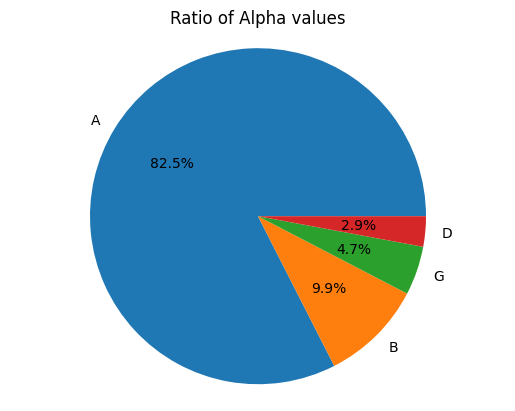

In [8]:
import matplotlib.pyplot as plt

# Calculate value counts of 'Alpha'
alpha_counts = df_greeks['Alpha'].value_counts()

# Calculate ratios
alpha_ratios = alpha_counts / len(df_greeks)

# Plot alpha ratios as a pie chart
plt.pie(alpha_ratios, labels=alpha_ratios.index, autopct='%1.1f%%')
plt.title('Ratio of Alpha values')
plt.axis('equal')
plt.show()



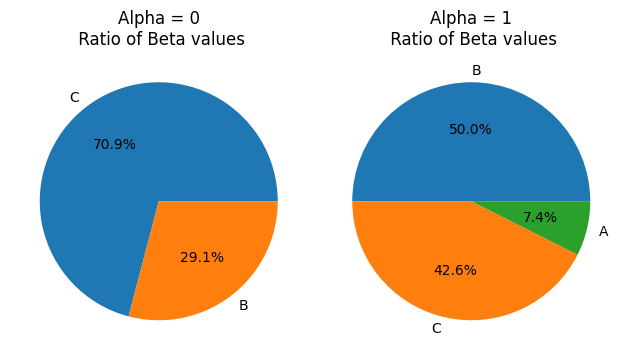

In [7]:
# To plot the portion of 'Beta' values when 'Alpha' is equal to 0 and 1 separately
import matplotlib.pyplot as plt

# Filter DataFrame for Alpha = 0
alpha_0_df = df_greeks[df_greeks['Alpha'] == 'A']
beta_counts_0 = alpha_0_df['Beta'].value_counts()

# Plot portion of Beta values for Alpha = 0
plt.subplot(121)
plt.pie(beta_counts_0, labels=beta_counts_0.index, autopct='%1.1f%%')
plt.title("Alpha = 0\n Ratio of Beta values")

# Filter DataFrame for Alpha = 1
alpha_1_df = df_greeks[df_greeks['Alpha'] !='A' ]
beta_counts_1 = alpha_1_df['Beta'].value_counts()

# Plot portion of Beta values for Alpha = 1
plt.subplot(122)
plt.pie(beta_counts_1, labels=beta_counts_1.index, autopct='%1.1f%%')
plt.title("Alpha = 1\n Ratio of Beta values")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


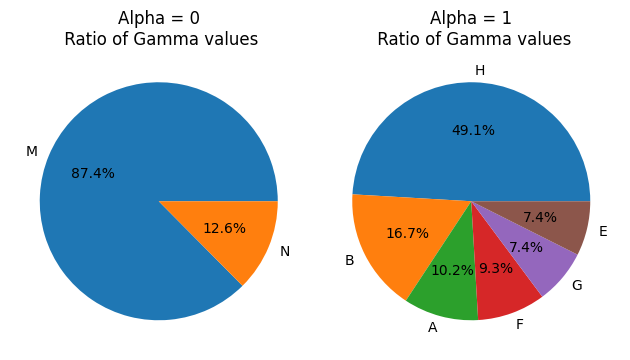

In [8]:
# Filter DataFrame for Alpha = 0
alpha_0_df = df_greeks[df_greeks['Alpha'] == 'A']
beta_counts_0 = alpha_0_df['Gamma'].value_counts()

# Plot portion of Beta values for Alpha = 0
plt.subplot(121)
plt.pie(beta_counts_0, labels=beta_counts_0.index, autopct='%1.1f%%')
plt.title("Alpha = 0\n Ratio of Gamma values")

# Filter DataFrame for Alpha = 1
alpha_1_df = df_greeks[df_greeks['Alpha'] !='A' ]
beta_counts_1 = alpha_1_df['Gamma'].value_counts()

# Plot portion of Beta values for Alpha = 1
plt.subplot(122)
plt.pie(beta_counts_1, labels=beta_counts_1.index, autopct='%1.1f%%')
plt.title("Alpha = 1\n Ratio of Gamma values")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



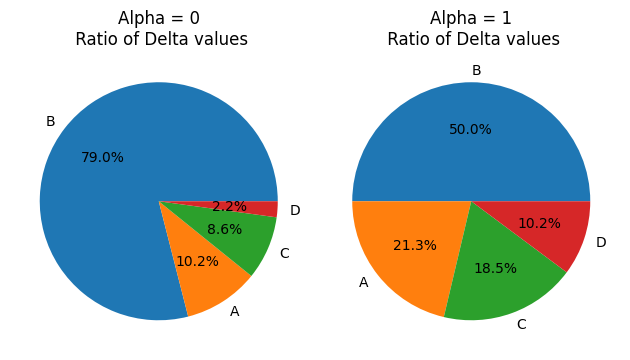

In [9]:
# Filter DataFrame for Alpha = 0
alpha_0_df = df_greeks[df_greeks['Alpha'] == 'A']
beta_counts_0 = alpha_0_df['Delta'].value_counts()

# Plot portion of Beta values for Alpha = 0
plt.subplot(121)
plt.pie(beta_counts_0, labels=beta_counts_0.index, autopct='%1.1f%%')
plt.title("Alpha = 0\n Ratio of Delta values")

# Filter DataFrame for Alpha = 1
alpha_1_df = df_greeks[df_greeks['Alpha'] !='A' ]
beta_counts_1 = alpha_1_df['Delta'].value_counts()

# Plot portion of Beta values for Alpha = 1
plt.subplot(122)
plt.pie(beta_counts_1, labels=beta_counts_1.index, autopct='%1.1f%%')
plt.title("Alpha = 1\n Ratio of Delta values")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



## Perform one-hot encoding on categorical variables 'Beta', 'Gamma', and 'Delta' 

In [10]:

encoded_df = pd.get_dummies(df_greeks, columns=['Beta','Gamma', 'Delta'])

# Display the encoded DataFrame
encoded_df.head()

,Id,Alpha,Epsilon,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,B,3/19/2019,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,D,3/25/2020,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


In [11]:
encoded_df.head()

,Id,Alpha,Epsilon,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,B,3/19/2019,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,A,Unknown,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,D,3/25/2020,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


# Part II: Data cleaning

## Analysis of NaN values

In [12]:
import pandas as pd

# Assuming you have a DataFrame named df_train
nan_counts = df_train.isna().sum()
nonzero_nan_counts = nan_counts[nan_counts != 0]

print(nonzero_nan_counts)


BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64


* df_train: There are about 10% NAN values in EL and BQ columns. 
* df_test: No NAN values
* df_greeks: No Nan values


## Analysis of Outliers 


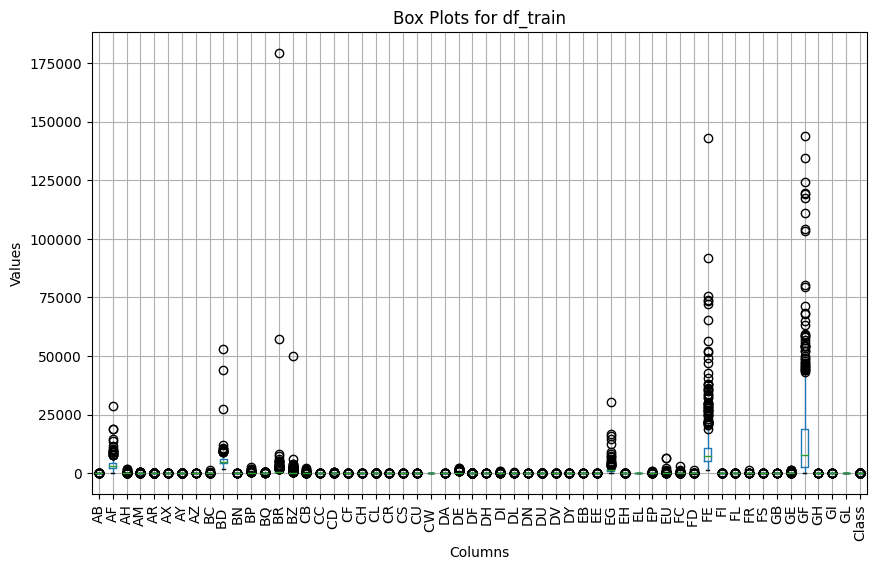

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is stored in a DataFrame named df_train

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots for each column in df_train
df_train.boxplot(ax=ax)

# Set the title and labels
ax.set_title('Box Plots for df_train')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()


In [14]:
df_train[['GF','FE','BD ','BR','AF','EG','EU','BZ','BQ']]

,GF,FE,BD,BR,AF,EG,EU,BZ,BQ
0,2003.810319,9028.291921,4126.58731,823.928241,3109.03329,1433.166750,3.828384,257.432377,152.707705
1,27981.562750,6785.003474,5496.92824,51.216883,978.76416,1111.287150,52.260480,257.432377,14.754720
2,13676.957810,8338.906181,5135.78024,482.141594,2635.10654,1494.076488,5.390628,257.432377,219.320160
3,2094.262452,10965.766040,4169.67738,661.518640,3819.65177,15691.552180,31.323372,257.432377,11.050410
4,8524.370502,16198.049590,5728.73412,6074.859475,3733.04844,1403.656300,51.141336,257.432377,149.717165
...,...,...,...,...,...,...,...,...,...
612,8095.932828,17167.209610,4157.68439,365.516874,3130.05946,495.086300,65.821872,257.432377,27.287375
613,3085.308063,18460.330020,5654.07556,505.006814,5462.03438,1722.674025,447.657600,257.432377,344.644105
614,6474.652866,5088.922912,5888.87769,2083.880500,2459.10720,2565.402825,3.828384,257.432377,103.988995
615,1965.343176,6464.250832,4517.86560,722.377629,1263.53524,1318.962875,8.259384,257.432377,NaN


## Missing values imputation and Standization

In [15]:
outlier_list =['GF','FE','BD ','BR','AF','EG','EU','BZ','BQ']
# Apply log(x+1) transformation to the specified columns
df_train[outlier_list] = np.log1p(df_train[outlier_list])
#df_train[outlier_list]= df_train[outlier_list].apply(lambda x: 1 / x)

In [13]:
df_train[outlier_list]

,GF,FE,BD,BR,AF,EG,EU,BZ,BQ
0,7.603305,9.108229,8.325448,6.715296,8.042389,7.268339,1.574512,5.554634,5.035053
1,10.239337,8.822617,8.612127,3.955406,6.887312,7.014174,3.975195,5.554634,2.757140
2,9.523541,9.028807,8.544182,6.180310,7.877058,7.309933,1.854833,5.554634,5.395082
3,7.647434,9.302625,8.335834,6.496049,8.248176,9.660941,3.475791,5.554634,2.489099
4,9.050802,9.692708,8.653424,8.712079,8.225248,7.247548,3.953958,5.554634,5.015405
...,...,...,...,...,...,...,...,...,...
612,8.999241,9.750815,8.332954,5.904045,8.049127,6.206750,4.202030,5.554634,3.342416
613,8.034731,9.823434,8.640309,6.226550,8.605760,7.452213,6.106260,5.554634,5.845410
614,8.775805,8.535018,8.680991,7.642467,7.807960,7.850261,1.574512,5.554634,4.653856
615,7.583931,8.774197,8.416016,6.583931,7.142460,7.185359,2.225638,5.554634,NaN


In [17]:

#(df_train[outlier_list])

df_train['EJ'] = df_train.EJ.map({'A':0,'B':1}).astype(float)
feature_list_KNN = list(set(df_train.columns) - set(['Id','EJ','Class','BQ','EL']))
feature_list = list(set(df_train.columns) - set(['Id','Class','BQ','EL']))
# Filling missing values
# perform KNN imputation features
# perform KNN imputation features
imputer = KNNImputer(n_neighbors=5)
df_train[feature_list_KNN] = imputer.fit_transform(df_train[feature_list_KNN])
# Feature scaling
scaler = StandardScaler()
df_train[feature_list_KNN] = scaler.fit_transform(df_train[feature_list_KNN])

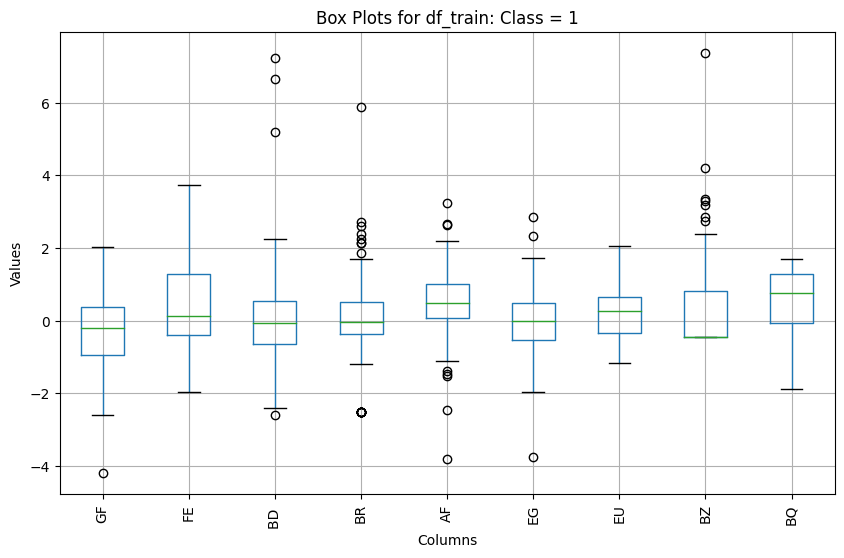

In [18]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots for each column in df_train
df_train[df_train['Class'] == 1][outlier_list].boxplot(ax=ax)

# Set the title and labels
ax.set_title('Box Plots for df_train: Class = 1')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

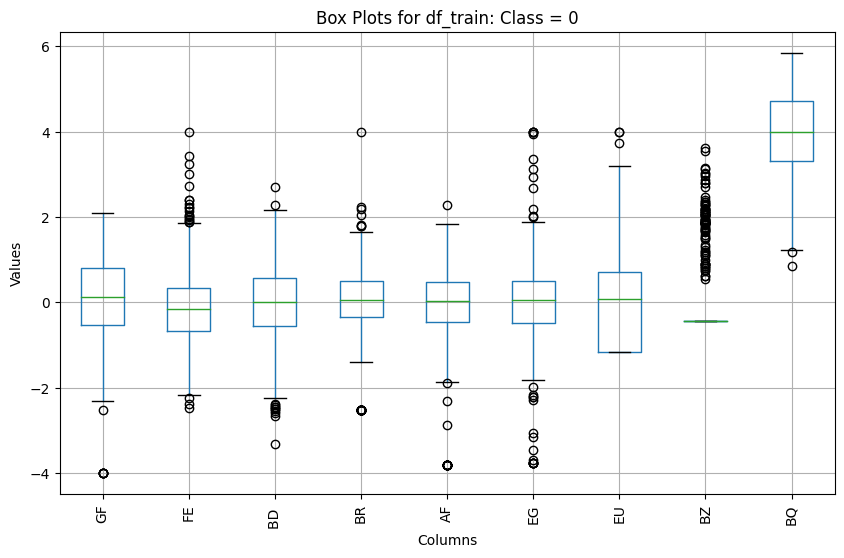

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots for each column in df_train
df_train[df_train['Class'] == 0][outlier_list].boxplot(ax=ax)

# Set the title and labels
ax.set_title('Box Plots for df_train: Class = 0')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [18]:

# Cap and floor the values of df_train within the range of -4 to 4
df_train[feature_list_KNN]=df_train[feature_list_KNN].clip(lower=-2, upper=4)


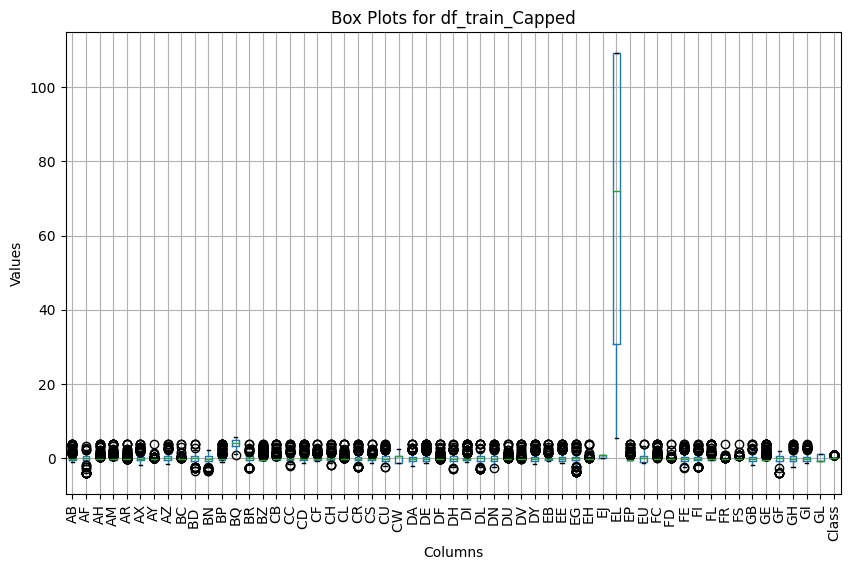

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots for each column in df_train
df_train.boxplot(ax=ax)

# Set the title and labels
ax.set_title('Box Plots for df_train_Capped')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')

# Rotate x-axis labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

# Part III: Deep learning model

In [22]:
merged_df = df_train.merge(encoded_df, on='Id')
merged_df

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,-0.572153,0.110642,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,...,0,0,1,0,0,0,0,0,0,1
1,007255e47698,-0.709105,-1.520469,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,...,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,-0.015212,-0.122825,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,...,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,-0.480851,0.401240,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,...,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,-0.206946,0.368863,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,-0.699975,0.120157,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,...,0,0,0,0,1,0,0,1,0,0
613,fd895603f071,-0.088253,0.906192,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,...,0,0,0,0,1,0,0,1,0,0
614,fd8ef6377f76,-0.106514,-0.220400,0.090140,0.235206,-0.011673,0.990330,-0.083417,1.113828,-0.104787,...,0,0,0,0,1,0,0,1,0,0
615,fe1942975e40,-0.243466,-1.160169,-0.261669,-0.219353,-0.189295,0.955584,-0.083417,-0.699741,-0.104787,...,0,0,0,0,1,0,0,1,0,0


## Upsample the positive samples (class=1) to have the same size as the negative samples (class=0)

In [62]:
import pandas as pd

# Separate positive and negative samples
positive_samples = merged_df[merged_df['Class'] == 1]
negative_samples = merged_df[merged_df['Class'] == 0]

# Upsample positive samples to match the size of negative samples
upsampled_positive_samples = positive_samples.sample(n=len(negative_samples), replace=True)

# Combine the upsampled positive samples with the negative samples
balanced_data = pd.concat([negative_samples, upsampled_positive_samples])

# Shuffle the rows in the balanced DataFrame
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

X = balanced_data[feature_list].values
y1 = balanced_data['Class'].values
y2 = balanced_data[['Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
                'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A',
                'Delta_B', 'Delta_C', 'Delta_D']].values



In [24]:
'''X = merged_df[feature_list].values
y1 = merged_df['Class'].values
y2 = merged_df[['Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
                'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'Delta_A',
                'Delta_B', 'Delta_C', 'Delta_D']].values'''

In [64]:
# Split the data into training and testing sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, stratify=y1,random_state=42)


# Method: Custom Loss Function and Model Selection with Auxiliary Learning
The method aims to train a neural network model with a main target ('Class') and auxiliary targets ('Beta', 'Gamma', 'Delta') to improve overall performance.
## Custom Loss Function
Defining a custom loss function called custom_loss. This loss function combines two individual losses, loss1 and loss2, using a weighting factor lambda_val. The custom loss function is implemented using the TensorFlow Keras backend. It calculates the binary cross-entropy loss for each target and combines them with the specified weight. The value of lambda_val can be adjusted as desired to control the influence of the auxiliary loss.
## Model Training and Selection
The method proceeds with model training and selection using a checkpoint callback and early stopping callback. The training process is performed iteratively for a predefined number of times (e.g., 10 times) to evaluate different model configurations.

Within each iteration, a neural network model is built with shared layers and separate branches for the main target ('Class') and auxiliary targets ('Beta', 'Gamma', 'Delta'). The model architecture consists of densely connected layers with activation functions and regularization. The main output layer uses the sigmoid activation function, while the additional features branch uses the sigmoid activation function as well.



In [65]:
from sklearn.utils import class_weight

def custom_loss(y_true, y_pred):
    loss1 = K.binary_crossentropy(K.cast(y_true[0], dtype='float32'), y_pred[0])
    loss2 = K.binary_crossentropy(K.cast(y_true[1], dtype='float32'), y_pred[1])
    lambda_val = 0.2  # Adjust the value of lambda as desired
    print(loss1,loss2)
    loss = loss1+ lambda_val * loss2
    return loss

best_model = None
best_val_accuracy = -1

# Define a checkpoint callback to save the weights of the best model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_main_output_accuracy', mode='max', verbose=1)

# Define an early stopping callback with patience
early_stopping = EarlyStopping(monitor='val_main_output_accuracy', mode='max', patience=5, verbose=1)
learning_rate = 0.0001  # Set the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Run the model 10 times and select the best model
for i in range(10):
    # Build the neural network model
    input_shape = (X_train.shape[1],)
    input_layer = Input(shape=input_shape)
    
    # Shared layers
    shared_layer1 = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input_layer)
    shared_layer2 = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(shared_layer1)
    shared_layer_output = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(shared_layer2)
    
    # Main branch - 'Class'
    main_output = Dense(1, activation='sigmoid', name='main_output')(shared_layer_output)
    
    # Additional features branch
    additional_output = Dense(y2.shape[1], activation='sigmoid', name='additional_output')(shared_layer_output)
    
    # Combine the outputs
    model = Model(inputs=input_layer, outputs=[main_output, additional_output])
    
    # Compile the model with the custom loss function and class weights for target 1
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=['accuracy'])
     
    # Train the model with the checkpoint and early stopping callbacks
    model.fit(X_train, [y1_train, y2_train], validation_data=(X_test, [y1_test, y2_test]), epochs=50, batch_size=32, callbacks=[checkpoint, early_stopping])
   # Evaluate the model on the validation set
    loss, main_loss, additional_loss, main_accuracy, additional_accuracy = model.evaluate(X_test, [y1_test, y2_test], verbose=1)
    val_accuracy = main_accuracy  # Get the accuracy value

    # Check if this model has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_model = model
        best_val_accuracy = val_accuracy
    
# The best model is stored in 'best_model'
selected_model = best_model
print(best_val_accuracy)

Epoch 1/50
Tensor("custom_loss/Neg:0", shape=(1,), dtype=float32) Tensor("custom_loss/Neg_1:0", shape=(1,), dtype=float32)
Tensor("custom_loss_1/Neg:0", shape=(15,), dtype=float32) Tensor("custom_loss_1/Neg_1:0", shape=(15,), dtype=float32)
Tensor("custom_loss/Neg:0", shape=(1,), dtype=float32) Tensor("custom_loss/Neg_1:0", shape=(1,), dtype=float32)
Tensor("custom_loss_1/Neg:0", shape=(15,), dtype=float32) Tensor("custom_loss_1/Neg_1:0", shape=(15,), dtype=float32)
18/26 [===================>..........] - ETA: 0s - loss: 1.6854 - main_output_loss: 0.8460 - additional_output_loss: 0.8292 - main_output_accuracy: 0.5660 - additional_output_accuracy: 0.0035     Tensor("custom_loss/Neg:0", shape=(1,), dtype=float32) Tensor("custom_loss/Neg_1:0", shape=(1,), dtype=float32)
Tensor("custom_loss_1/Neg:0", shape=(15,), dtype=float32) Tensor("custom_loss_1/Neg_1:0", shape=(15,), dtype=float32)

Epoch 1: val_main_output_accuracy improved from -inf to 0.57353, saving model to best_model.h5
26/26 [

## Train the selected sele_model using only the main branch

In [66]:
# Select the main branch for training
model = Model(inputs=selected_model.input, outputs=selected_model.get_layer('main_output').output)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the main model using the selected model's weights
model.fit(X, y1, epochs=15, batch_size=32, callbacks=[checkpoint, early_stopping])



Epoch 1/15
32/32 [==============================] - 1s 3ms/step - loss: 0.4916 - accuracy: 0.8310
Epoch 2/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4857 - accuracy: 0.8320
Epoch 3/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.8369
Epoch 4/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.8448
Epoch 5/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.8507
Epoch 6/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.8546
Epoch 7/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4575 - accuracy: 0.8556
Epoch 8/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.8605
Epoch 9/15
32/32 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.8674
Epoch 10/15
32/32 [==============================] - 0s 3ms/step - loss: 0.4409 - accuracy: 0.8644
Epoch 11/15
32/32 [

# Part IV: Submmision

In [40]:
df_test = pd.read_csv(dataset_directory / 'test.csv')

# Apply log(x+1) transformation to the specified columns
df_test[outlier_list] = np.log1p(df_test[outlier_list])
df_test['EJ'] = df_test.EJ.map({'A':0,'B':1}).astype(float)
df_test[feature_list_KNN] = imputer.fit_transform(df_test[feature_list_KNN])
df_test[feature_list_KNN] = scaler.fit_transform(df_test[feature_list_KNN])
# Cap and floor the values of df_train within the range of -4 to 4
df_test[feature_list_KNN] = df_test[feature_list_KNN].clip(lower=-2, upper=4)

# Make predictions
predictions = model.predict(df_test[feature_list])

1/1 [==============================] - 0s 105ms/step


In [41]:
sub = df_test[['Id']].copy()
sub['Class_0'] = 1-predictions
sub['Class_1'] = predictions
sub.to_csv('submission.csv',index=False)